Например, на бирке Вы можете увидеть следующее: **1Бр Кр57 - 0,31 1/3А**. Разберем, что означают эти цифры и буквы на бирке:

    1Бр - это 1 бриллиант круглой огранки;
    Кр57 - это круглая огранка 57 граней;
    0,31 - это вес в каратах: 0,31 карата высшей чистоты;
    1/3 - первая цифра обозначает группу цвета, вторая - группу чистоты;
    [А] - группа качества огранки.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.simplefilter('ignore')

In [ ]:
url = 'https://raw.githubusercontent.com/Theodore-Ptr/Hackathon/main/data/full_rings.csv'
df = pd.read_csv(url, sep=",", index_col=0)
df = df.drop_duplicates()
df.drop("price_after_discount", axis=1, inplace=True)

In [ ]:
df

,matter,injection_params,weight,size,is_defect,platemark,type,price_before_takeoff
0,gold,"3 фианит 0,8 Круг",1.86,15.0,1,585,wedding,1062.86
1,gold,"3 фианит 0,8 Круг",1.90,15.0,0,585,wedding,865.87
3,gold,"3 фианит 0,8 Круг",1.72,15.0,0,585,wedding,783.84
7,gold,"3 фианит 0,8 Круг",1.75,15.0,0,585,wedding,797.51
8,gold,"3 фианит 0,8 Круг",1.78,15.0,0,585,wedding,1017.15
...,...,...,...,...,...,...,...,...
23425,gold,"3 Фианит Кр 2,00 0,033;",3.00,17.5,0,585,decorative,1969.41
23426,gold,"19 Фианит Кр 1,00 0,032;",2.35,18.5,0,585,decorative,1561.86
23427,gold,"19 Фианит Кр 1,00 0,032;",2.41,19.0,0,585,decorative,1601.73
23428,gold,"21 Фианит Кр 1,00 0,036;",2.09,17.0,0,585,decorative,1412.86


In [ ]:
nums_features = make_column_selector(dtype_include=np.number)
cats_features = make_column_selector(dtype_include=object)

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    The class provides basic functionality for retrieving
    a subset of columns from the dataset.
    """
    
    def __init__(self, feature_names):
        """
        Initialize class instance by setting
        a list of columns to retrieve from the dataset.
        """
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        """
        Fit FeatureSelector to X, but really do nothing.
        Return self.
        """
        return self
    
    def transform(self, X, y=None):
        """
        Transform X using feature selection. 
        Return column-subset of X.
        """
        return X[self.feature_names]

In [ ]:
class ParseInjection(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        i = 0
        for inj in X.injection_params:
            if inj == "None":
                i += 1
                continue
            stones = dict()
            inj_strs = (inj.replace(', ', '|').replace('. ', '|')
                        .replace(';', '|').split('|'))
            for inj_substr in inj_strs:
                str_split = inj_substr.split()
                if len(str_split) < 3: 
                  continue
                if str_split[0].isdigit() and (str_split[1].isalpha() or 
                                               str_split[1] in ["Кер.кольцо", "Гор.хр"]):
                    stones.setdefault(str_split[1].lower(), 0)
                    stones[str_split[1].lower()] += int(str_split[0])
                elif any([True if "БРКр" in x else False for x in str_split]):
                    for sub in str_split:
                        if "БРКр" in sub:
                            stones.setdefault("бриллиант", 0)
                            br_num = sub.split("БРКр")[0]
                            stones["бриллиант"] += (int(br_num) if "Родий" not in sub 
                                                    else int(br_num.split("Родий")[1]))
                elif str_split[0][1:] in ["Сапфир", "Изумруд"]:
                    stones.setdefault(str_split[0][1:].lower(), 0)
                    stones[str_split[0][1:].lower()] += int(str_split[0][0])
                elif str_split[0].isdigit() and str_split[2] in ["Сапфир", "Изумруд"]:
                    stones.setdefault(str_split[2].lower(), 0)
                    stones[str_split[2].lower()] += int(str_split[0])
                elif len(str_split) > 2 and str_split[2] == "Эмаль":
                    stones.setdefault(str_split[2].lower(), 0)
                    stones[str_split[2].lower()] += int(str_split[0])
            for name, num in stones.items():
                name = name if name not in ["бр", "брилл"] else "бриллиант"
                X.loc[X.index[i], name] = num
            i += 1
        return X.drop(["injection_params"], axis=1)

In [ ]:
class NoiseCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, rate=5):
        """
        cleans instances and columns that do not have significant impact
        """
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.rate= rate
        
    def fit(self, X, y=None):
        """
        Fit NoiseCleaner to X, but really do nothing.
        Return self.
        """
        return self
    
    
    def transform(self, X, y=None):
        clean_up_mask = X.count() >  self.rate
        for row, flag in zip(clean_up_mask.index, clean_up_mask):
            if flag == False:
                X.drop(row, axis = 1, inplace=True)
        return X

In [ ]:
class PlatemarkTransformer(BaseEstimator, TransformerMixin):
    """
    The class provides functionality for converting matter
    columns to year values. Extracts year from string.
    """
    
    def __init__(self, drop=False):
        """
        Initializes class instance by setting convert options. 
        
        Parameters
        ----------
        drop: bool, 
            if True, removes the original columns from the dataset.
        """
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.drop = drop
    
    def fit(self, X, y=None):
        """
        Fit DateTransformer to X, but really do nothing.
        Return self.
        """
        return self
    
    def transform(self, X, y=None):
        """
        Transfor X using the parameters set in the constructor.
        Return transformed dataframe.
        """
        X['matter'] = X['matter'].add(str(X['platemark']))
        X = pd.get_dummies(X, columns=['matter'])
        if self.drop:
            X.drop('platemark', axis=1, inplace=True)
        return X

In [ ]:
X = df.drop(["price_before_takeoff"], axis=1)
y = df.price_before_takeoff

In [ ]:
pi = ParseInjection().fit(X)
X = pi.transform(X)

In [ ]:
cats = ["type"]
platemark_col = ["platemark", "matter"]
injection = X.columns[6:]
nums = ["weight", "size"]
defect = ["is_defect"]

In [ ]:
cats_ohe = OneHotEncoder(sparse=False)
cats_pipe = make_pipeline(FeatureSelector(cats), cats_ohe)

In [ ]:
injection_pipe = make_pipeline(FeatureSelector(injection), NoiseCleaner(), 
                               SimpleImputer(missing_values=np.nan, 
                                             strategy='constant', fill_value=0))

In [ ]:
nums_scaler = StandardScaler()
nums_pipe = make_pipeline(FeatureSelector(nums), nums_scaler)

In [ ]:
defect_pipe = make_pipeline(FeatureSelector(defect))

In [ ]:
pt = PlatemarkTransformer(drop=True)
platemark_pipe = make_pipeline(FeatureSelector(platemark_col), pt)

In [ ]:
full_pipe = FeatureUnion(
    transformer_list=[
      ("cats", cats_pipe),
      ("injection", injection_pipe),
      ("nums", nums_pipe),
      ("defect", defect_pipe),
      ("platemark", platemark_pipe)
    ]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    shuffle=True, test_size=0.2)

In [ ]:
full_pipe.fit(X_train, y_train)
full_pipe.transform(X_train)[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.12207001,
        1.16501349,  0.        ,  0.        ,  1.        ])

In [ ]:
extra_tree = ExtraTreesRegressor(random_state=42, n_jobs=-1, criterion="mae")
tree_pipe = make_pipeline(full_pipe, extra_tree)
tree_pipe

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('cats',
                                                 Pipeline(memory=None,
                                                          steps=[('featureselector',
                                                                  FeatureSelector(feature_names=['type'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories='auto',
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                                                                handle_unknown='error',
                                                                                sparse=False)

In [ ]:
tree_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('cats',
                                                 Pipeline(memory=None,
                                                          steps=[('featureselector',
                                                                  FeatureSelector(feature_names=['type'])),
                                                                 ('onehotencoder',
                                                                  OneHotEncoder(categories='auto',
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                                                                handle_unknown='error',
                                                                                sparse=False)

#Visualization comes below:


### Correlogram

In [ ]:
def show_numeric_correlogram(df):
    numeric_features = df.select_dtypes('number').columns

    mask = np.triu(np.ones_like(numeric_features, dtype=bool))

    figure, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(df[numeric_features].corr(),
                vmin=-1, vmax=1, cmap='RdBu',
                annot=True, center=0, mask = mask)
    plt.title('Numeric values dataset correlogram', fontsize=20)
    plt.show()

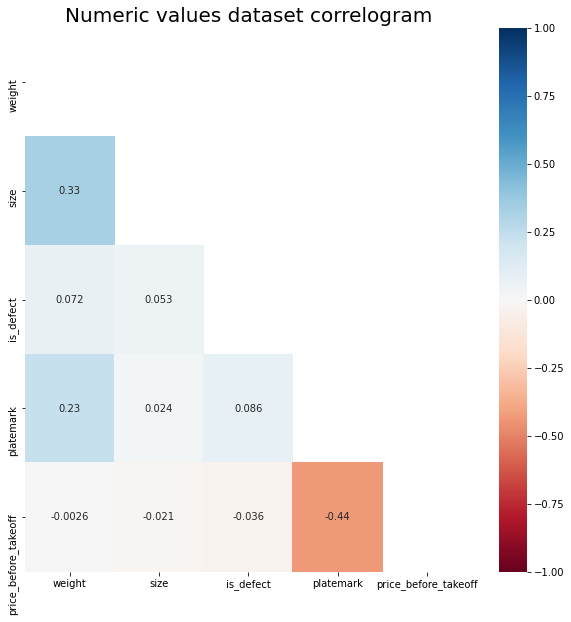

In [ ]:
show_numeric_correlogram(df)

### Price distribution by various features

In [ ]:
fig = px.box(df, y="price_before_takeoff", x = 'matter')
fig.show()

In [ ]:
no_inj_mask = df['injection_params'].eq('None')
inj_mask = df['injection_params'].ne('None')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(x=df[inj_mask]['price_before_takeoff']))
fig.add_trace(go.Box(x=df[no_inj_mask]['price_before_takeoff']))
fig.show()

In [ ]:
price_table_1 = df.groupby(['matter', 'platemark']).price_before_takeoff.agg(['mean', 'median', 'min', 'max'])
price_table_1

In [ ]:
price_table_2 = df.groupby(['type', 'is_defect']).price_before_takeoff.agg(['mean', 'median', 'min', 'max'])
price_table_2

## Price by weight:

In [ ]:
plt.subplots(figsize=(16, 9), dpi=80)
to_plot_weight = df[(df['price_before_takeoff'] < 3000) & (df['weight'] <= 3.5)]
sns.lineplot(x=to_plot_weight.weight, y=to_plot_weight.price_before_takeoff)
plt.show()

Price by size of the ring

In [ ]:
plt.subplots(figsize=(16, 9), dpi=80)
sns.lineplot(x=df['size'], y=df.price_before_takeoff)
plt.show()

### Platemark distribution

In [ ]:
fig = px.pie(df, values='platemark', names='platemark')
fig.show()